# Harry Potter and the Data Mining Project #

### Our goal ###
To extract as much information as we can from the Harry Potter book series written by J.K. Rowling.

### Our methods ###
We used web scraping for obtaining our data from https://thefreeonlinenovel.com/series/b/harry-potter

We had to go theough multiple refininf steps to get it in the format that we need.

Afterwards we applied the studies methods of data cleaning, separating into words, sentiment analysis, and others.

In [223]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from tidytext import unnest_tokens
import nltk
from afinn import Afinn
from siuba import *
import plotly.graph_objects as go
import plotly.express as px

nltk.download('punkt')

import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib import pyplot as plt
from tidytext import *
from nltk import *
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import gensim
from gensim import corpora, models

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
scores = sia.polarity_scores('Yay')

import pyLDAvis.gensim_models

nltk.download('stopwords')
afinn = Afinn()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Web Scraping #

This is the function that we used for exctrating a single chapter from the website.

We noticed that the newlines, tabs and other non-alphanumeric characters were shown in their "printable" form.

We replaced them with a blank space, as we will split the data into words later.

In [20]:
def getChapterContent(url, chapter):
    page = requests.get(url + str(chapter))
    soup = BeautifulSoup(page.content, 'html.parser')
    elem = soup.find("td").findAll(text=True, recursive=False)
    
    
    foundTitle = False
    text = ""
    for el in elem:
        string = str(el)
        
        if re.search('[a-zA-Z]', string):
            
            string = string.replace('\n', " ")
            string = string.replace('\t', " ")
            string = string.replace('\r', " ")
            string = string.replace('\u3000', "")
            string = string.replace("<br />", "")
            string = string.replace("&uml;C", "")
            string = string.replace("\'", "'")
            
            if not foundTitle:
                title = string
                foundTitle = True
            else:
                text += string
    
    return title, text

Here we have the functions for writing and readind the json files with the books

In [21]:
def writeBook(i, url, titles, texts):
    json_book = dict()
    
    json_book["url"] = url
    
    json_book["title"] = url.split("/")[-1]
    json_book["title"] = json_book["title"].split("_")[0]
    
    json_book["no_chapters"] = len(titles)
    json_book["titles"] = titles
    json_book["content"] = texts
    
    print(json_book["title"])
    
    f = open("HarryPotter_Book"+str(i), "w")
    f.write(json.dumps(json_book))

In [22]:
def readBook(i):
    g = open("HarryPotter_Book"+str(i), "r")
    file = g.read().splitlines()[0]
    info = json.loads(file)
    
    return info

We created a list of the urls so the process is smoothers

The below cells <b> can be avoided </b> when running the notebook <b> if </b> the json files are downloaded (https://github.com/danielbociat/DataMining)

In [23]:
urls = [
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-sorcerers-stone_chapter-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-chamber-of-secrets_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-prisoner-of-azkaban_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-goblet-of-fire_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-order-of-the-phoenix_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-half-blood-prince_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-deathly-hallows_page-'
]

In [24]:
for i in range(len(urls)):
    url = urls[i]
    
    all_titles = list()
    all_texts = list()
    chapter = 1
    while True:
        try:
            title, text = getChapterContent(url, chapter)
            all_titles.append(title)
            all_texts.append(text)
            #print("Current chapter: ", chapter)
            chapter += 1
        except Exception as e:
            #print(e)
            break
    
    writeBook(i+1, url, all_titles, all_texts)
    print("Book: ", i+1)
    print("Total chapters: ", chapter-1)
    word_count = 0
    for text in all_texts:
        word_count += len(text.split(" "))
    print("Total words: ",word_count)
    print("\n")

harry-potter-and-the-sorcerers-stone
Book:  1
Total chapters:  17
Total words:  78626


harry-potter-and-the-chamber-of-secrets
Book:  2
Total chapters:  19
Total words:  86287


harry-potter-and-the-prisoner-of-azkaban
Book:  3
Total chapters:  22
Total words:  106277


harry-potter-and-the-goblet-of-fire
Book:  4
Total chapters:  37
Total words:  193535


harry-potter-and-the-order-of-the-phoenix
Book:  5
Total chapters:  38
Total words:  284048


harry-potter-and-the-half-blood-prince
Book:  6
Total chapters:  30
Total words:  171832


harry-potter-and-the-deathly-hallows
Book:  7
Total chapters:  37
Total words:  203505




# Converting the books to dataframes # 

We had to save the chapters in the json files as there was no "keyword" to signal the start of a new chapter

We also save both the name and the id of the book, so it is easier to search through them and print information

In [25]:
def getRawBooksToDF():
    df = pd.DataFrame(columns=['content', 'chapter', 'book'])

    for i in range(7):
        info = readBook(i+1)

        book_text = ''.join((chapter for chapter in info["content"]))
        generator = ngrams(word_tokenize(book_text.lower()), 2)
        
        curr_df = pd.DataFrame({
            "content": info["content"],
            "chapter": list(range(1,info["no_chapters"]+1))
        })
        curr_df["book"] = info['title']
        curr_df["book_id"] = int(i+1)

        df = pd.concat([df, curr_df])

    df.reset_index(drop=True, inplace=True) 
    return df

# N-Grams  #

We created a general function to get the n-grams

We also added an additional parameter to choose if we remove the stop words or not

It will be used in a section below

In [26]:
def getNgrams(n, remove_stopwords):
    ngrams_df = pd.DataFrame(columns=["book", "ngrams"])

    for i in range(7):
        info = readBook(i+1)
        basic_stop_words = stopwords.words('english')
        punctuation_signs = ['\'',"...", "''", ';', "-", "<", ">", '"', ',', '.', '!', '?', '/', '[', ']', '(', ')', '“', '”', '’', '‘', '``', "--"]
        custom_stop_words = ["'nt","'s","a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]
        basic_stop_words.extend(custom_stop_words)
        basic_stop_words.extend(punctuation_signs)
        
        book_text = ''.join((chapter for chapter in info["content"]))
        ngrams_generator = ngrams(word_tokenize(book_text.lower()), n)
        ngrams_array = [ ' '.join(grams) for grams in ngrams_generator]
        
        ngrams_filtered = []
        
        if remove_stopwords:
            basic_stop_words = set(basic_stop_words)
        else:
            basic_stop_words = set(punctuation_signs)
        
        
        for ngram in ngrams_array:
             ngram_words = ngram.split()
             ok = True
             for word in ngram_words:
                if word in basic_stop_words:
                    ok = False
                    break
             if ok:
                ngrams_filtered.append(ngram)

        temp_ngrams_df = pd.DataFrame({
            "book": info['title'],
            "ngrams": ngrams_filtered
        })
        
        ngrams_df = pd.concat([ngrams_df, temp_ngrams_df])
        ngrams_df.reset_index(drop=True, inplace=True)
        
        
    return ngrams_df

# Data cleaning #

We use the following function to remove stopwords

Fun fact: the data is pretty clean already and the line "ss_df = ss_df[ss_df.word.notnull()]" does nothing, but we have it just in case

In [224]:
def removeStopWordsDF(ss_df):
    ss_df = (unnest_tokens(ss_df, "word", "content"))
    ss_df = ss_df[ss_df.word.notnull()]
    ss_df = ss_df[~ss_df['word'].isin(stopwords.words('english'))]
    ss_df.reset_index(drop=True, inplace=True)
    
    return ss_df
    

In [154]:
full_df = getRawBooksToDF()

In [155]:
pd.set_option('display.max_rows', 200)
full_df

,content,chapter,book,book_id
0,"Mr. and Mrs. Dursley, of number four, Privet D...",1,harry-potter-and-the-sorcerers-stone,1.0
1,Nearly ten years had passed since the Dursleys...,2,harry-potter-and-the-sorcerers-stone,1.0
2,The escape of the Brazilian boa constrictor ea...,3,harry-potter-and-the-sorcerers-stone,1.0
3,BOOM. They knocked again. Dudley jerked awake....,4,harry-potter-and-the-sorcerers-stone,1.0
4,Harry woke early the next morning. Although he...,5,harry-potter-and-the-sorcerers-stone,1.0
5,Harry's last month with the Dursleys wasn't fu...,6,harry-potter-and-the-sorcerers-stone,1.0
6,"The door swung open at once. A tall, black-hai...",7,harry-potter-and-the-sorcerers-stone,1.0
7,"There, look."" ""Where?"" ""Next to the tall kid w...",8,harry-potter-and-the-sorcerers-stone,1.0
8,Harry had never believed he would meet a boy h...,9,harry-potter-and-the-sorcerers-stone,1.0
9,Malfoy couldn't believe his eyes when he saw t...,10,harry-potter-and-the-sorcerers-stone,1.0


In [156]:
ss_df = removeStopWordsDF(full_df)

In [157]:
ss_df

,chapter,book,book_id,word
0,1,harry-potter-and-the-sorcerers-stone,1.0,mr
1,1,harry-potter-and-the-sorcerers-stone,1.0,mrs
2,1,harry-potter-and-the-sorcerers-stone,1.0,dursley
3,1,harry-potter-and-the-sorcerers-stone,1.0,number
4,1,harry-potter-and-the-sorcerers-stone,1.0,four
...,...,...,...,...
583323,37,harry-potter-and-the-deathly-hallows,7.0,pained
583324,37,harry-potter-and-the-deathly-hallows,7.0,harry
583325,37,harry-potter-and-the-deathly-hallows,7.0,nineteen
583326,37,harry-potter-and-the-deathly-hallows,7.0,years


In [159]:
cnt = count(ss_df, 'word', sort=True)

# Word cloud #

Here we created a basic word cloud based on the frequency of the words

In case there are error messages, ignore them and scroll for the picture

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2

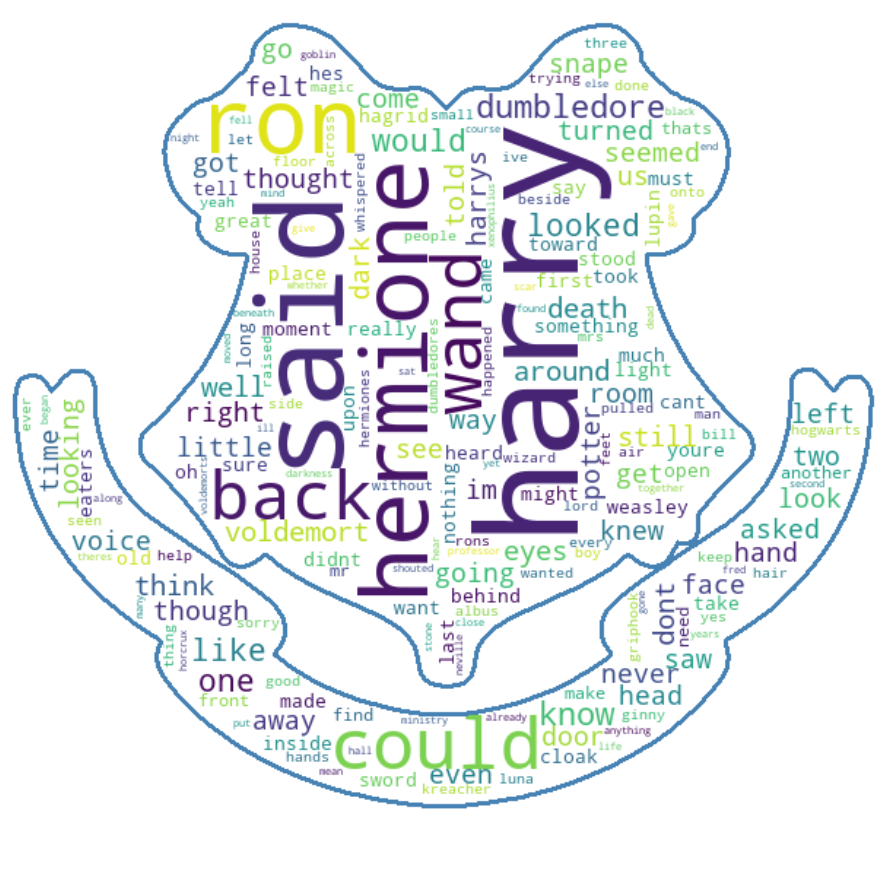

In [225]:
word_freq = pd.Series(cnt.n.values,index=cnt.word).to_dict()

mask = np.array(Image.open("Hogwarts-Logo-PNG-Transparent.png"))
mask[mask == 0] = 255

wordcloud = WordCloud(background_color='white',mask=mask, width=1000, height=800, contour_width=3, contour_color='steelblue',stopwords=[]).generate_from_frequencies(word_freq)
plt.figure(figsize = (16, 16), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word frequency overall and per book #

Below you will find the frequency on the wholse series, as well as graphs with the frequency of the words per book

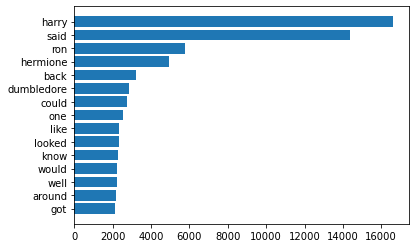

In [161]:
countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

In [162]:
count(ss_df, 'word', sort=True)

,word,n
0,harry,16613
1,said,14393
2,ron,5747
3,hermione,4928
4,back,3199
...,...,...
24086,cryin,1
24087,crybabies,1
24088,crutches,1
24089,crusty,1


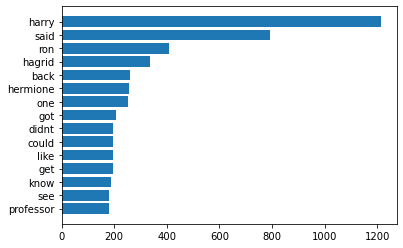

In [163]:
cnt = count(ss_df[ss_df["book_id"] == 1], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

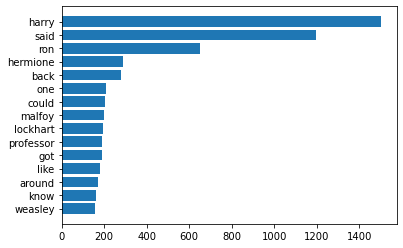

In [164]:
cnt = count(ss_df[ss_df["book_id"] == 2], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

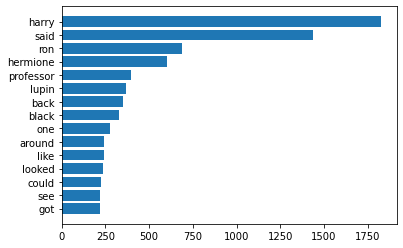

In [165]:
cnt = count(ss_df[ss_df["book_id"] == 3], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

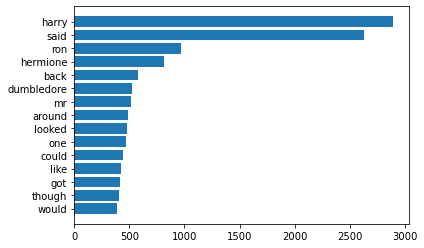

In [166]:
cnt = count(ss_df[ss_df["book_id"] == 4], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

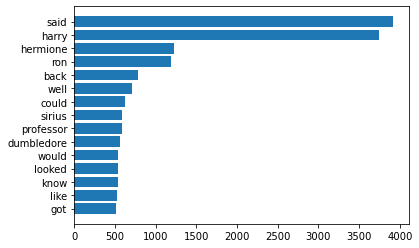

In [167]:
cnt = count(ss_df[ss_df["book_id"] == 5], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

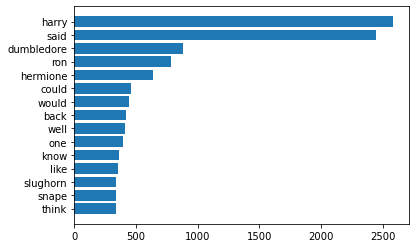

In [168]:
cnt = count(ss_df[ss_df["book_id"] == 6], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

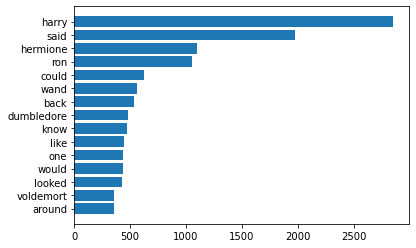

In [169]:
cnt = count(ss_df[ss_df["book_id"] == 7], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

In [170]:
harry_potter_df = count(ss_df, _.book,  _.word, sort=True)

In [171]:
harry_potter_df

,book,word,n
0,harry-potter-and-the-order-of-the-phoenix,said,3917
1,harry-potter-and-the-order-of-the-phoenix,harry,3749
2,harry-potter-and-the-goblet-of-fire,harry,2892
3,harry-potter-and-the-deathly-hallows,harry,2852
4,harry-potter-and-the-goblet-of-fire,said,2627
...,...,...,...
66430,harry-potter-and-the-order-of-the-phoenix,innovation,1
66431,harry-potter-and-the-order-of-the-phoenix,innocently,1
66432,harry-potter-and-the-order-of-the-phoenix,innocentlooking,1
66433,harry-potter-and-the-deathly-hallows,stainedglass,1


# TF_IDF # 

Computing the tf_idf we can find the most relevant/impactful words in every book

As we expected the more impactful ones are name of characters

In [172]:
book_tf_idf = bind_tf_idf(harry_potter_df, 'word', 'book', 'n')
book_tf_idf


,book,word,n,tf,idf,tf_idf
0,harry-potter-and-the-order-of-the-phoenix,said,3917,0.028088,0.000000,0.000000
1,harry-potter-and-the-order-of-the-phoenix,harry,3749,0.026883,0.000000,0.000000
2,harry-potter-and-the-goblet-of-fire,harry,2892,0.028168,0.000000,0.000000
3,harry-potter-and-the-deathly-hallows,harry,2852,0.027682,0.000000,0.000000
4,harry-potter-and-the-goblet-of-fire,said,2627,0.025587,0.000000,0.000000
...,...,...,...,...,...,...
66430,harry-potter-and-the-order-of-the-phoenix,innovation,1,0.000007,1.945910,0.000014
66431,harry-potter-and-the-order-of-the-phoenix,innocently,1,0.000007,0.336472,0.000002
66432,harry-potter-and-the-order-of-the-phoenix,innocentlooking,1,0.000007,1.252763,0.000009
66433,harry-potter-and-the-deathly-hallows,stainedglass,1,0.000010,1.945910,0.000019


In [173]:
arrange(book_tf_idf, -_.tf_idf)

,book,word,n,tf,idf,tf_idf
97,harry-potter-and-the-half-blood-prince,slughorn,337,0.003743,1.252763,0.004689
44,harry-potter-and-the-order-of-the-phoenix,umbridge,497,0.003564,0.847298,0.003020
247,harry-potter-and-the-goblet-of-fire,bagman,208,0.002026,1.252763,0.002538
279,harry-potter-and-the-chamber-of-secrets,lockhart,194,0.004091,0.559616,0.002289
82,harry-potter-and-the-prisoner-of-azkaban,lupin,369,0.006328,0.336472,0.002129
...,...,...,...,...,...,...
66205,harry-potter-and-the-deathly-hallows,staff,1,0.000010,0.000000,0.000000
66236,harry-potter-and-the-deathly-hallows,stage,1,0.000010,0.000000,0.000000
66355,harry-potter-and-the-deathly-hallows,contrary,1,0.000010,0.000000,0.000000
66380,harry-potter-and-the-order-of-the-phoenix,inky,1,0.000007,0.000000,0.000000


In [174]:
tf_idf_df = ungroup(group_by(arrange(book_tf_idf, -_.tf_idf), 'book').head(10))
tf_idf_df

,book,word,n,tf,idf,tf_idf
97,harry-potter-and-the-half-blood-prince,slughorn,337,0.003743,1.252763,0.004689
44,harry-potter-and-the-order-of-the-phoenix,umbridge,497,0.003564,0.847298,0.003020
247,harry-potter-and-the-goblet-of-fire,bagman,208,0.002026,1.252763,0.002538
279,harry-potter-and-the-chamber-of-secrets,lockhart,194,0.004091,0.559616,0.002289
82,harry-potter-and-the-prisoner-of-azkaban,lupin,369,0.006328,0.336472,0.002129
473,harry-potter-and-the-goblet-of-fire,winky,145,0.001412,1.252763,0.001769
1018,harry-potter-and-the-goblet-of-fire,champions,85,0.000828,1.945910,0.001611
1056,harry-potter-and-the-deathly-hallows,xenophilius,83,0.000806,1.945910,0.001568
637,harry-potter-and-the-deathly-hallows,griphook,119,0.001155,1.252763,0.001447
1497,harry-potter-and-the-half-blood-prince,mclaggen,65,0.000722,1.945910,0.001405


In [175]:
ordered_tf_idf_df = arrange(tf_idf_df, _.book, -_.tf_idf)
ordered_tf_idf_df

,book,word,n,tf,idf,tf_idf
279,harry-potter-and-the-chamber-of-secrets,lockhart,194,0.004091,0.559616,0.002289
504,harry-potter-and-the-chamber-of-secrets,dobby,139,0.002931,0.336472,0.000986
2894,harry-potter-and-the-chamber-of-secrets,gilderoy,37,0.000780,1.252763,0.000977
2258,harry-potter-and-the-chamber-of-secrets,myrtle,47,0.000991,0.847298,0.000840
808,harry-potter-and-the-chamber-of-secrets,riddle,100,0.002109,0.336472,0.000709
2829,harry-potter-and-the-chamber-of-secrets,lockharts,38,0.000801,0.847298,0.000679
8570,harry-potter-and-the-chamber-of-secrets,stall,12,0.000253,1.945910,0.000492
8746,harry-potter-and-the-chamber-of-secrets,kwikspell,12,0.000253,1.945910,0.000492
1498,harry-potter-and-the-chamber-of-secrets,diary,64,0.001349,0.336472,0.000454
2973,harry-potter-and-the-chamber-of-secrets,justin,36,0.000759,0.559616,0.000425


# tf_idf graphs #

Below you can find graph of the tf_idf for every book

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is d

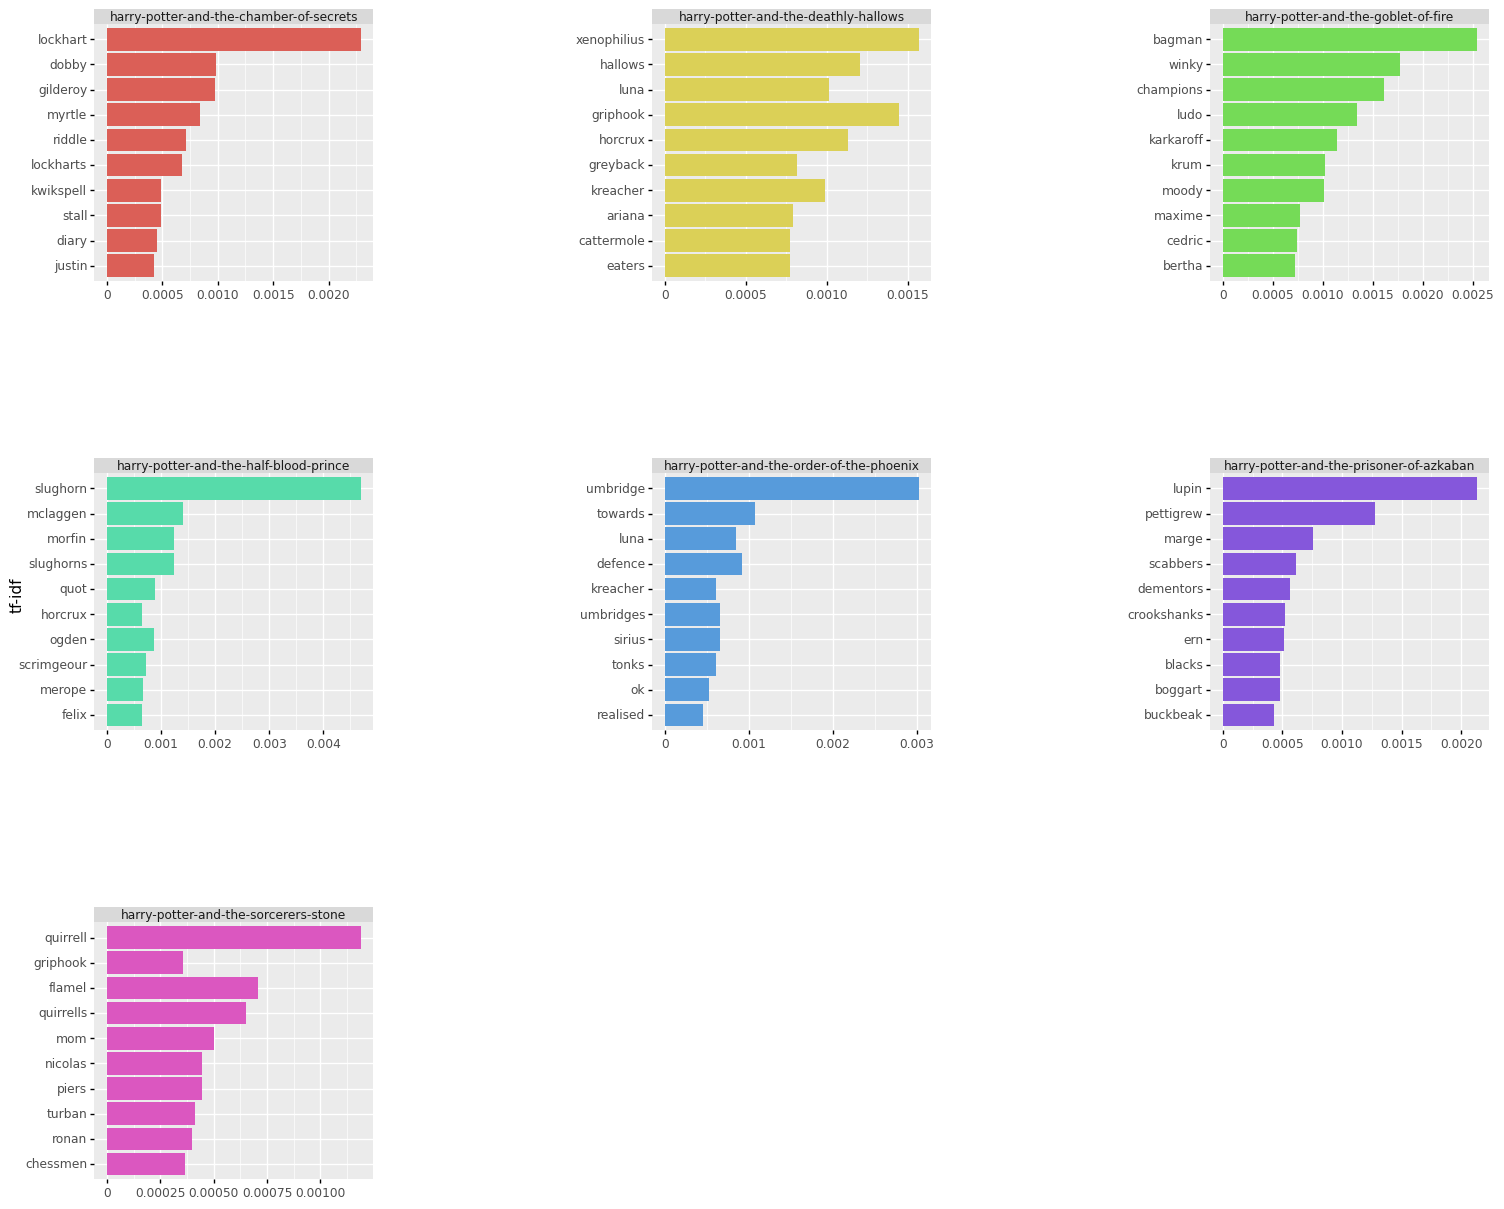

<ggplot: (-9223371908335504072)>

In [176]:
from siuba.dply.forcats import fct_reorder
from plotnine import *

ggplt = (ggplot(ordered_tf_idf_df)  + theme(figure_size=(18, 15)) + aes(x=fct_reorder(ordered_tf_idf_df['word'], x=ordered_tf_idf_df['tf_idf']), y='tf_idf', fill='book') + coord_flip() + geom_col(show_legend = False) + facet_wrap('~book', ncol = 3, scales = "free") + labs(x = "tf-idf", y = None) + theme(subplots_adjust={'wspace': 0.25}) + theme(subplots_adjust={'wspace': 1, 'hspace': 0.75}) + scale_x_discrete() ) 
ggplt

# Ngrams part 2  #

Here our expectations were a bit crushed as we expected certain ngrams to be at the top

Some examples of unmet expectations: "Harry Potter" for bigrams, "He who must not be named" for 6grams and "the boy who lived" for 4grams

In [177]:
bigrams = getNgrams(2, True)
trigrams = getNgrams(3, False)
fourgrams = getNgrams(4, False)
sixgrams = getNgrams(6, False)

In [178]:
bigrams

,book,ngrams
0,harry-potter-and-the-sorcerers-stone,mrs. dursley
1,harry-potter-and-the-sorcerers-stone,privet drive
2,harry-potter-and-the-sorcerers-stone,perfectly normal
3,harry-potter-and-the-sorcerers-stone,'d expect
4,harry-potter-and-the-sorcerers-stone,n't hold
...,...,...
110107,harry-potter-and-the-deathly-hallows,harry looked
110108,harry-potter-and-the-deathly-hallows,hand absentmindedly
110109,harry-potter-and-the-deathly-hallows,lightning scar
110110,harry-potter-and-the-deathly-hallows,pained harry


In [179]:
trigrams

,book,ngrams
0,harry-potter-and-the-sorcerers-stone,mr. and mrs.
1,harry-potter-and-the-sorcerers-stone,and mrs. dursley
2,harry-potter-and-the-sorcerers-stone,of number four
3,harry-potter-and-the-sorcerers-stone,were proud to
4,harry-potter-and-the-sorcerers-stone,proud to say
...,...,...
765840,harry-potter-and-the-deathly-hallows,not pained harry
765841,harry-potter-and-the-deathly-hallows,pained harry for
765842,harry-potter-and-the-deathly-hallows,harry for nineteen
765843,harry-potter-and-the-deathly-hallows,for nineteen years


In [180]:
sixgrams

,book,ngrams
0,harry-potter-and-the-sorcerers-stone,were proud to say that they
1,harry-potter-and-the-sorcerers-stone,proud to say that they were
2,harry-potter-and-the-sorcerers-stone,to say that they were perfectly
3,harry-potter-and-the-sorcerers-stone,say that they were perfectly normal
4,harry-potter-and-the-sorcerers-stone,they were the last people you
...,...,...
427958,harry-potter-and-the-deathly-hallows,the lightning scar on his forehead
427959,harry-potter-and-the-deathly-hallows,the scar had not pained harry
427960,harry-potter-and-the-deathly-hallows,scar had not pained harry for
427961,harry-potter-and-the-deathly-hallows,had not pained harry for nineteen


In [181]:
bigrams_count = count(bigrams, _.ngrams, sort=True)
bigrams_count.head(15)

,ngrams,n
0,professor mcgonagall,616
1,uncle vernon,450
2,mrs. weasley,417
3,mr. weasley,409
4,harry potter,357
5,wo n't,350
6,death eaters,346
7,harry looked,320
8,harry felt,262
9,common room,228


In [182]:
trigrams_count = count(trigrams, _.ngrams, sort=True)
trigrams_count.head(30)

,ngrams,n
0,out of the,788
1,i do n't,676
2,there was a,554
3,ron and hermione,438
4,in front of,394
5,harry and ron,318
6,as though he,296
7,fred and george,285
8,the end of,277
9,one of the,268


In [183]:
sixgrams_count = count(sixgrams, _.ngrams, sort=True)
sixgrams_count.head(20)

,ngrams,n
0,on the other side of the,45
1,hogwarts school of witchcraft and wizardry,20
2,out of the corner of his,18
3,at the far end of the,18
4,defense against the dark arts teacher,18
5,of the order of the phoenix,17
6,at the foot of the stairs,14
7,the defense against the dark arts,13
8,for the first time in his,13
9,from the other side of the,13


In [184]:
fourgrams_count = count(fourgrams, _.ngrams, sort=True)
fourgrams_count.head(20)

,ngrams,n
0,the rest of the,185
1,i do n't know,178
2,i do n't think,157
3,against the dark arts,129
4,the ministry of magic,120
5,the end of the,114
6,at the end of,110
7,out of the way,94
8,for the first time,93
9,i 'm going to,92


After looking through multiple ngrams, we decided to look for exact information

In our case we looked after professor names and dark magin/wizards

In [185]:
bigrams_words = bigrams
bigrams_words[['word1', 'word2']] = bigrams_words['ngrams'].str.split(expand=True)

count(filter(bigrams_words, _.word1=='professor'), _.book, _.word1, _.word2, sort=True)

,book,word1,word2,n
0,harry-potter-and-the-order-of-the-phoenix,professor,umbridge,180
1,harry-potter-and-the-order-of-the-phoenix,professor,mcgonagall,149
2,harry-potter-and-the-prisoner-of-azkaban,professor,lupin,116
3,harry-potter-and-the-sorcerers-stone,professor,mcgonagall,95
4,harry-potter-and-the-prisoner-of-azkaban,professor,mcgonagall,89
5,harry-potter-and-the-chamber-of-secrets,professor,mcgonagall,83
6,harry-potter-and-the-prisoner-of-azkaban,professor,trelawney,83
7,harry-potter-and-the-goblet-of-fire,professor,mcgonagall,81
8,harry-potter-and-the-half-blood-prince,professor,mcgonagall,69
9,harry-potter-and-the-order-of-the-phoenix,professor,trelawney,55


In [186]:
count(filter(bigrams_words, _.word1=='professor'), _.word1, _.word2, sort=True)

,word1,word2,n
0,professor,mcgonagall,616
1,professor,trelawney,208
2,professor,umbridge,181
3,professor,dumbledore,130
4,professor,lupin,125
5,professor,snape,90
6,professor,flitwick,88
7,professor,sprout,71
8,professor,grubbly-plank,42
9,professor,binns,33


In [187]:
count(filter(bigrams_words, _.word1=='dark'), _.word1, _.word2, sort=True).head(20)

,word1,word2,n
0,dark,arts,175
1,dark,lord,166
2,dark,mark,53
3,dark,magic,24
4,dark,wizard,21
5,dark,wizards,15
6,dark,eyes,14
7,dark,hair,13
8,dark,grounds,11
9,dark,corridor,11


In [188]:
count(filter(bigrams_words, _.word1=='dark'), _.book, _.word1, _.word2, sort=True).head(20)

,book,word1,word2,n
0,harry-potter-and-the-half-blood-prince,dark,lord,57
1,harry-potter-and-the-order-of-the-phoenix,dark,arts,52
2,harry-potter-and-the-deathly-hallows,dark,lord,43
3,harry-potter-and-the-half-blood-prince,dark,arts,38
4,harry-potter-and-the-order-of-the-phoenix,dark,lord,36
5,harry-potter-and-the-goblet-of-fire,dark,mark,31
6,harry-potter-and-the-goblet-of-fire,dark,arts,25
7,harry-potter-and-the-prisoner-of-azkaban,dark,arts,23
8,harry-potter-and-the-half-blood-prince,dark,mark,17
9,harry-potter-and-the-goblet-of-fire,dark,lord,17


# Sentiment Analysis #

The first method that we used is using the Afinn scored

Dataframes and graphs found below


In [189]:
word_scores = [afinn.score(word) for word in ss_df['word']]
ss_word_scores_df = ss_df.assign(word_score = word_scores)

grouped_ss_df = group_by(ss_word_scores_df, 'chapter', 'book', 'book_id')
summarized_ss_df = summarize(grouped_ss_df, chapter_score = _.word_score.sum())
summarized_book_ss_df = summarize(group_by(ss_word_scores_df, 'book', 'book_id'), book_score = _.word_score.sum())
summarized_ss_df

,chapter,book,book_id,chapter_score
0,1,harry-potter-and-the-chamber-of-secrets,2.0,-13.0
1,1,harry-potter-and-the-deathly-hallows,7.0,16.0
2,1,harry-potter-and-the-goblet-of-fire,4.0,-99.0
3,1,harry-potter-and-the-half-blood-prince,6.0,-138.0
4,1,harry-potter-and-the-order-of-the-phoenix,5.0,-105.0
5,1,harry-potter-and-the-prisoner-of-azkaban,3.0,55.0
6,1,harry-potter-and-the-sorcerers-stone,1.0,64.0
7,2,harry-potter-and-the-chamber-of-secrets,2.0,-50.0
8,2,harry-potter-and-the-deathly-hallows,7.0,-28.0
9,2,harry-potter-and-the-goblet-of-fire,4.0,-89.0


In [190]:
from plotnine import *
summarized_ss_df = summarized_ss_df.sort_values(by=['book_id', 'chapter'], ascending=True)
summarized_ss_df.reset_index(drop=True, inplace=True) 
book_list = list()
temp_list = list(summarized_ss_df['book'])
for book in temp_list:
    if book not in book_list:
        book_list.append(book)

graphs = []
for book in book_list: 
    book_filtered_summarized_ss_df = summarized_ss_df[summarized_ss_df['book'] == book]
    graphs.append((ggplot(book_filtered_summarized_ss_df)
     + aes(x='chapter', y='chapter_score')
     + geom_bar(stat='identity')
    ))

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


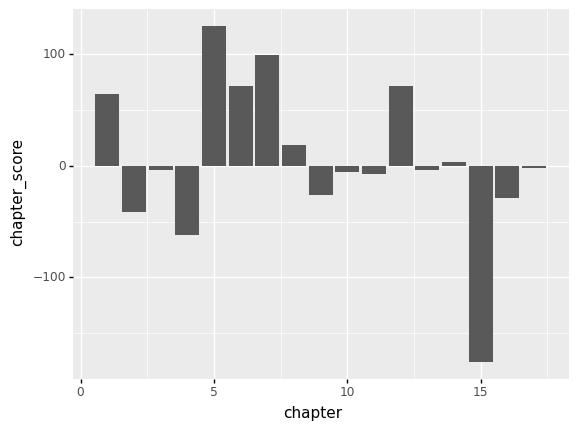

<ggplot: (-9223371908339560244)>

In [191]:
graphs[0]

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


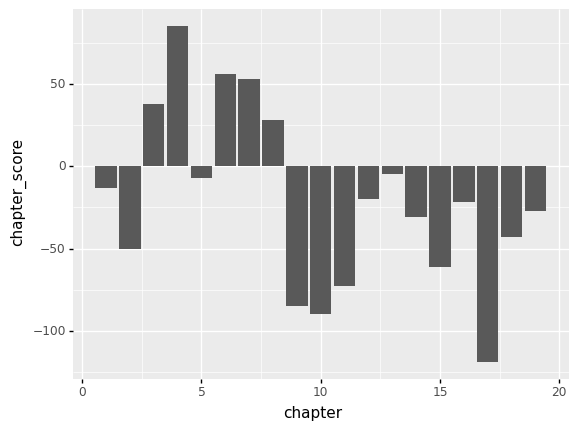

<ggplot: (-9223371908339642508)>

In [192]:
graphs[1]

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


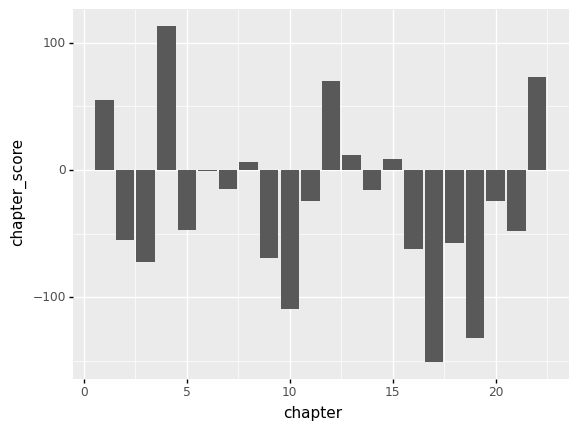

<ggplot: (-9223371908339655604)>

In [193]:
graphs[2]

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


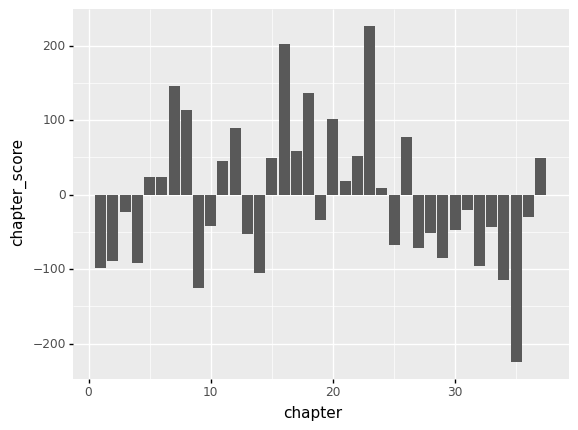

<ggplot: (-9223371908339591452)>

In [194]:
graphs[3]

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


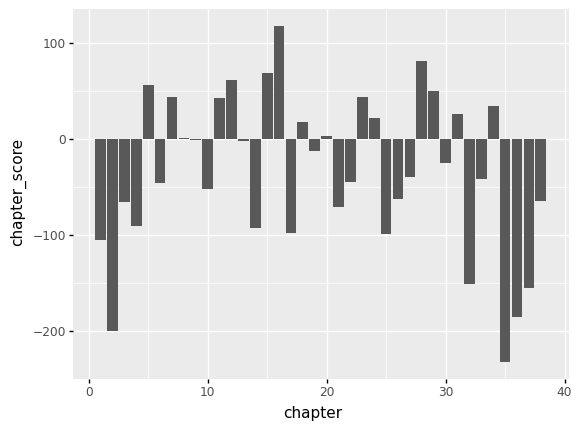

<ggplot: (-9223371908339581624)>

In [195]:
graphs[4]

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


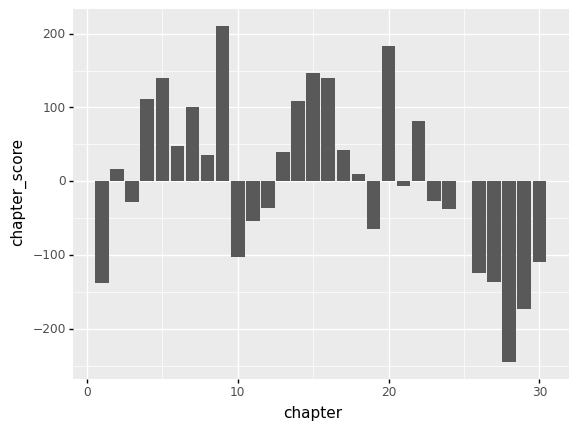

<ggplot: (-9223371908339532784)>

In [196]:
graphs[5]

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\plotnine\geoms\geom_rect.py:70: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.


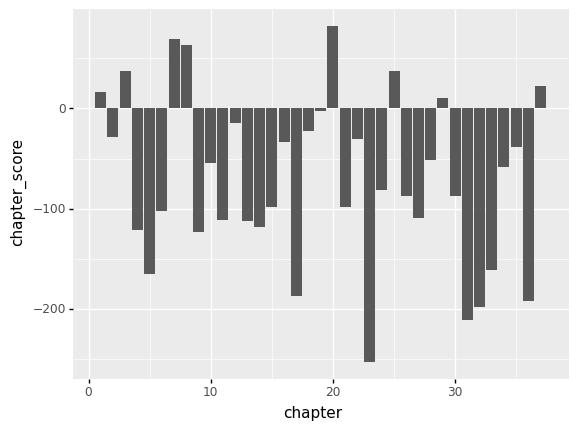

<ggplot: (-9223371908354401144)>

In [197]:
graphs[6]

### The second method that we used was using NRCLex ###

In [217]:

for i in range(7):
    info = readBook(i+1)
    
    print("Book: ", info['title'])
    
    full_text = ""
    
    for ch in info["content"]:
        full_text += ch
    
    text_object = NRCLex(full_text)
    text_object.lexicon

    print(text_object.top_emotions, '\n')

    print(dict(sorted(text_object.raw_emotion_scores.items(), key=lambda item: -item[1])), '\n')

    print(dict(sorted(text_object.affect_frequencies.items(), key=lambda item: -item[1])), '\n')

Book:  harry-potter-and-the-sorcerers-stone
[('negative', 0.17730330048490536)] 

{'negative': 2267, 'positive': 2203, 'anticipation': 1322, 'trust': 1285, 'fear': 1217, 'sadness': 1065, 'joy': 933, 'anger': 904, 'surprise': 799, 'disgust': 791} 

{'negative': 0.17730330048490536, 'positive': 0.1722978257469107, 'anticipation': 0.10339433755670265, 'trust': 0.10050054747379947, 'fear': 0.09518223056468011, 'sadness': 0.08329422806194275, 'joy': 0.07297043641482871, 'anger': 0.07070233067417488, 'surprise': 0.06249022368215235, 'disgust': 0.06186453933990302, 'anticip': 0.0} 

Book:  harry-potter-and-the-chamber-of-secrets
[('negative', 0.18707043211976862)] 

{'negative': 2749, 'positive': 2423, 'trust': 1505, 'fear': 1458, 'anticipation': 1370, 'sadness': 1258, 'anger': 1079, 'joy': 1012, 'disgust': 939, 'surprise': 902} 

{'negative': 0.18707043211976862, 'positive': 0.16488601565158217, 'trust': 0.10241578768288534, 'fear': 0.09921742089145968, 'anticipation': 0.09322898945219463, '

###  The third and final method was done using NLTK ###

In [222]:
for i in range(7):
    info = readBook(i+1)
    
    full_text = ""
    
    for ch in info["content"]:
        full_text += ch
        
    full_text = full_text.split()
    
    list_nltk_sentiments = [1 if sia.polarity_scores(word)['compound'] > 0 else -1 if sia.polarity_scores(word)['compound'] < 0 else 0 for word in full_text]
    
    print("Book: ", info['title'])
    print(sum(list_nltk_sentiments))

Book:  harry-potter-and-the-sorcerers-stone
205 

Book:  harry-potter-and-the-chamber-of-secrets
-34 

Book:  harry-potter-and-the-prisoner-of-azkaban
31 

Book:  harry-potter-and-the-goblet-of-fire
339 

Book:  harry-potter-and-the-order-of-the-phoenix
351 

Book:  harry-potter-and-the-half-blood-prince
604 

Book:  harry-potter-and-the-deathly-hallows
-801 



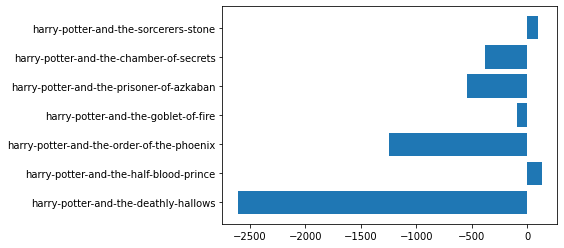

In [227]:
summarized_book_ss_df = summarized_book_ss_df.sort_values(by=['book_id'], ascending=False)
book_scores = summarized_book_ss_df['book_score']
books = summarized_book_ss_df['book']

plt.barh(books, book_scores, align='center')

plt.show()


In [198]:
summarized_book_ss_df

,book,book_id,book_score
0,harry-potter-and-the-chamber-of-secrets,2.0,-386.0
1,harry-potter-and-the-deathly-hallows,7.0,-2609.0
2,harry-potter-and-the-goblet-of-fire,4.0,-96.0
3,harry-potter-and-the-half-blood-prince,6.0,131.0
4,harry-potter-and-the-order-of-the-phoenix,5.0,-1249.0
5,harry-potter-and-the-prisoner-of-azkaban,3.0,-544.0
6,harry-potter-and-the-sorcerers-stone,1.0,95.0


# Topic Analysis #

Here we used Topic Analysis to separate the first 6 books into 3 categories and see where the last one fits

In [200]:

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [201]:
doc_set = []
for i in range(6):
    info = readBook(i+1)
    
    full_text = ""
    for chapter in info["content"]:
        full_text += chapter
    
    doc_set.append(full_text)

In [202]:
texts = []
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
#print(texts)
corpus = texts

In [203]:


# We are going to create a function for text preprocessing since we are going to be analyzing multiple texts and will want to reuse the code.
stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word)  > 5]

        return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [204]:
processed_data = [];
for doc in corpus:
    tokens = preprocess_text(doc)
    processed_data.append(tokens)


In [205]:
gensim_dictionary = corpora.Dictionary(processed_data)
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in processed_data]


In [136]:
lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=3, id2word=gensim_dictionary, passes=750)

topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic, '\n')

(0, '0.030*"hermion" + 0.016*"professor" + 0.013*"dumbledor" + 0.012*"around" + 0.012*"hagrid" + 0.011*"weasley" + 0.010*"though" + 0.008*"malfoy" + 0.008*"umbridg" + 0.007*"thought"') 

(1, '0.025*"hermion" + 0.017*"dumbledor" + 0.017*"hagrid" + 0.014*"around" + 0.011*"though" + 0.010*"weasley" + 0.010*"professor" + 0.008*"potter" + 0.007*"crouch" + 0.007*"thought"') 

(2, '0.033*"dumbledor" + 0.022*"hermion" + 0.013*"slughorn" + 0.012*"malfoy" + 0.010*"though" + 0.009*"around" + 0.009*"professor" + 0.009*"thought" + 0.008*"voldemort" + 0.007*"hagrid"') 



In [137]:
for g_corpus in gensim_corpus:
    print(lda_model[g_corpus])

[(0, 0.01099983), (1, 0.98896694)]
[(0, 0.9921704)]
[(0, 0.9953605)]
[(1, 0.9954377)]
[(0, 0.9986748)]
[(0, 0.014488948), (2, 0.9835646)]


### Following the result above we noticed that the books that are in category 0 also are the most negative books out of the 6 ###

### So, we expected the last book which is the most negative across all analysis methods to also be part of the same topic ###

In [226]:
info = readBook(7)
    
full_text = ""
for chapter in info["content"]:
    full_text += chapter


In [146]:
text_crumbs = preprocess_text(full_text)
text_crumbs = gensim_dictionary.doc2bow(text_crumbs)


In [147]:
topics = lda_model.get_document_topics(text_crumbs)

In [148]:
dict_auth = list(range(6))
for tp in topics:
    print("\t",dict_auth[tp[0]], tp[1])

	 0 0.32424128
	 1 0.36938623
	 2 0.3063725


###  But to our surprise it was not the case, as the last book is almost a perfect distribution across the 3 topics  ###

###  Remark: we tried to separate into 6 topics, but the results were underwhelming ###

In [151]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

C:\Users\danib\anaconda3\envs\Env1_3.7\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
